In [1]:
import numpy as np
import re
import math
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange as trange

#q = topic for each word
#pi = mixed topic distribution for document
#y = words
#b = word distribution per topic

vocab = set()
docs = []
 
D = 472 # number of documents
K = 10 # number of topics

# open each file; convert everything to lowercase and strip non-letter symbols; split into words
for fileind in range( 1, D+1 ):
    foo = open( 'files/output%04d.txt' % fileind ).read()    
    tmp = re.sub( '[^a-z]+', ' ', foo.lower() ).split()
    docs.append( tmp )
    for w in tmp:
        vocab.add( w )

# vocab now has unique words
# give each word in the vocab a unique id
ind = 0
vhash = {}
vindhash = {}
for i in list(vocab):
    vhash[i] = ind
    vindhash[ind] = i
    ind += 1

# size of our vocabulary
V = ind

# reprocess each document and re-represent it as a list of word ids
docs_i = []
for d in docs:
    dinds = []
    for w in d:
        dinds.append(vhash[w])
    docs_i.append(dinds)


# compute the likelihood by using 
def compute_data_likelihood(docs_i, qs, topics, pdtm):
        # sum of log likelihood
        ssum = 0
        for d,doc in enumerate(docs_i):
            for w,word in enumerate(doc):
                # k = topic of the word in that document
                k = qs[d][w]
                #add the probability of that word in that doc
                ssum += np.log(topics[k][word])
        return ssum
            
def randomly_assign_topics(docs_i, K):
    qs = []
    for doc in docs_i:
        qs.append(np.random.randint(0, high=K, size=len(doc)))
    return qs

def pdtm_resample(pdtm, alphas, cik):
    for d in xrange(D):
            pdtm[d] = np.random.dirichlet(alphas+cik[d])
    return pdtm

def topics_resample( topics, gammas, cvk):
    for k in xrange(K):
        topics[k] = np.random.dirichlet(gammas+cvk[:,k])
    return topics

#update civk and resample qs
def qs_resample(docs_i, qs, topics, pdtm, collapsed, cik, cvk, Li, gammas, alphas):
    for d,doc in enumerate(docs_i):
        for w,word in enumerate(doc):
            kbyword = np.zeros(K)
            for k in xrange(K):
                if (collapsed):
                    first = (cvk[word,k] + 1)/(ck[k]+V)
                    second = (cik[d,k] + 1)/(Li[d]+K)
                    kbyword[k] = first*second
                else:
                    kbyword[k] = pdtm[d][k]*topics[k][word]
            # norm kbyword
            kbyword /= np.sum(kbyword)
            formerk = qs[d][w]
            newk = np.random.choice(K, size = 1, p = kbyword)[0]
            
            #update all the civk data
            qs[d][w] = newk
            if(collapsed):
                ck[newk] +=1
                ck[formerk] -=1
            cvk[word,formerk] -=1
            cvk[word,newk] +=1
            cik[d,formerk] -=1
            cik[d, newk] +=1
    return qs

###########################################
qs = randomly_assign_topics( docs_i, K )


civk = np.zeros((D,V,K))
for d,doc in enumerate(docs_i):
    for w,word in enumerate(doc):
        k = qs[d][w]
        civk[d, word, k] += 1

cik = np.sum(civk, axis = 1)
cvk = np.sum(civk, axis = 0)
ck = np.sum(cik, axis = 0)
Li = np.sum(cik, axis = 1)
niv = np.sum(civk, axis = 2)


alphas = np.ones((K,1))[:,0]
gammas = np.ones((V,1))[:,0]

# topic distributions initialized as equal for each topic per word
topics = np.zeros((K,V))
for k in xrange(K):
        topics[k] = np.random.dirichlet(gammas+cvk[:,k])

#topics= np.random.dirichlet( gammas, K )

# per-document-topic distributions initialized as equal for each topic per document
pdtm = np.zeros((D, len(alphas)))
for d in range(D):
    pdtm[d] = np.random.dirichlet(alphas + cik[d])



In [2]:
plotpoints = np.zeros(100)
for iters in trange(0,100):
    p = compute_data_likelihood( docs_i, qs, topics, pdtm )
    if (iters%5 == 0):
        print "Iter %d, p=%.2f" % (iters,p)
    plotpoints[iters] = p
    # resample per-word topic assignments qs
    qs_resample(docs_i, qs, topics, pdtm, 0, cik, cvk, Li, gammas, alphas)
    # resample per-document topic mixtures = pdtm
    pdtm_resample(pdtm, alphas, cik)
    # resample topics
    topics_resample(topics, gammas, cvk)
    #resample civk

    

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Iter 0, p=-5367786.27
Iter 5, p=-5301304.56
Iter 10, p=-5273905.65
Iter 15, p=-5247220.46
Iter 20, p=-5214745.91
Iter 25, p=-5179641.59
Iter 30, p=-5152784.61
Iter 35, p=-5126783.22
Iter 40, p=-5109308.53
Iter 45, p=-5107973.20
Iter 50, p=-5116430.83
Iter 55, p=-5126845.05
Iter 60, p=-5133106.88
Iter 65, p=-5139866.43
Iter 70, p=-5148392.14
Iter 75, p=-5160120.26
Iter 80, p=-5167665.54
Iter 85, p=-5173493.43
Iter 90, p=-5174594.09
Iter 95, p=-5173276.13



In [3]:
data_likelihoods = []
pltpoints = np.zeros(100)
for iters in trange(0,100):
    p = compute_data_likelihood( docs_i, qs, topics, pdtm )
    if (iters%5 == 0):
        print "Iter %d, p=%.2f" % (iters,p)
    pltpoints[iters] = p
    qs_resample(docs_i, qs, topics, pdtm, 1, cik, cvk, Li, gammas, alphas)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Iter 0, p=-5171274.16
Iter 5, p=-5297095.49
Iter 10, p=-5295931.84
Iter 15, p=-5296107.07
Iter 20, p=-5301828.73
Iter 25, p=-5306432.23
Iter 30, p=-5312185.44
Iter 35, p=-5314403.82
Iter 40, p=-5315295.34
Iter 45, p=-5319195.04
Iter 50, p=-5321245.29
Iter 55, p=-5323001.38
Iter 60, p=-5326781.94
Iter 65, p=-5330230.16
Iter 70, p=-5334628.71
Iter 75, p=-5338100.71
Iter 80, p=-5343179.70
Iter 85, p=-5347217.66
Iter 90, p=-5352333.10
Iter 95, p=-5357000.61



(100,)


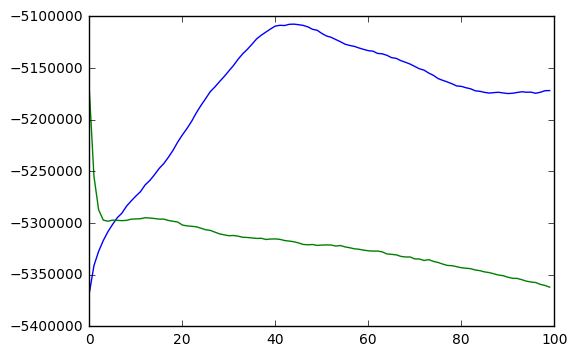

In [10]:
import matplotlib.pyplot as plt

it = np.arange(0,100)
print plotpoints.shape
plt.plot(it,plotpoints)
plt.plot(it,pltpoints)
plt.show()

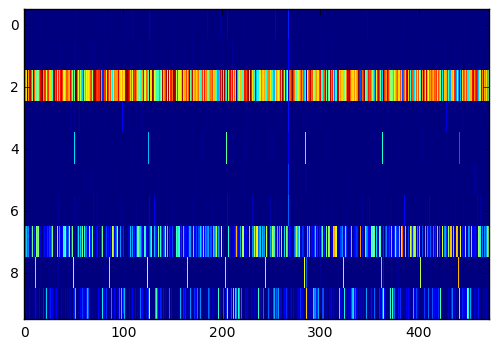

In [9]:
plt.imshow(pdtm.T, aspect='auto', interpolation='nearest', cmap='jet')
plt.show()
